#### <b>GAN의 수렴성 이해하기</b>

* 먼저 생성자(Generator)와 판별자(Discriminator) 아키텍처를 정의합니다.

In [1]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# 생성자(Generator)를 mu와 sigma를 파라미터로 갖는 정규 분포로 정의
class Generator:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    def sample(self, n):
        return np.random.normal(self.mu, self.sigma, n)


# 판별자(Discriminator)를 w를 파라미터로 갖는 함수로 정의
class Discriminator:
    def __init__(self, w):
        self.w = w
    def forward(self, x):
        return sigmoid(x * self.w)

* 원본 데이터를 준비한 뒤에 간단히 생성된 데이터와 함께 출력해 봅시다.

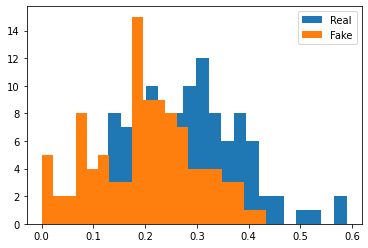

In [2]:
import numpy as np
import matplotlib.pyplot as plt


X = np.random.normal(0.3, 0.1, 100) # 원본 데이터
generator = Generator(mu=0.2, sigma=0.1)
generated_X = generator.sample(100) # 생성된 데이터

# 1차원의 데이터로, 값의 범위는 [0, 1]
X = np.clip(X, 0.001, 0.999) # 각 데이터를 [0.001, 0.999] 범위의 값으로 자르기
generated_X = np.clip(generated_X, 0.001, 0.999) # 각 데이터를 [0.001, 0.999] 범위의 값으로 자르기

# 데이터 시각화
plt.hist(X, bins=20)
plt.hist(generated_X, bins=20)
plt.legend(['Real', 'Fake'])
plt.show()

* 함수 <b>U(G, D)</b>를 정의합니다.

In [3]:
class U:
    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, is_D_optimal=False):
        generated_X = self.generator.sample(100) # 생성된 데이터
        generated_X = np.clip(generated_X, 0.001, 0.999) # 각 데이터를 [0.001, 0.999] 사이의 값으로 자르기
        # D가 완전히 최적화되어 Optimal Point를 갖는 경우
        if is_D_optimal:
            optimal_D = X / (X + generated_X)
            return np.mean(np.log(optimal_D) + np.log(1 - optimal_D))
        return np.mean(np.log(discriminator.forward(X)) + np.log(1 - discriminator.forward(generated_X)))

#### <b>U(G,D) 함수 그래프 출력</b>

* 함수 U(G,D)는 값이 <b>-log(4)</b>인 지점에서 <b>Optimal Saddle Point</b>를 갖습니다.

[Optimal Saddle Point] g_param = 0.28 / d_param = 0.03


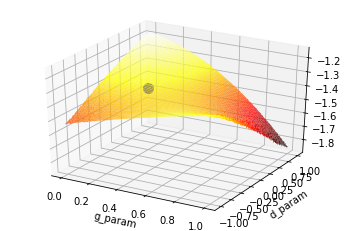

In [4]:
from matplotlib import cm

g_params = np.linspace(0, 1, 200)
d_params = np.linspace(-1, 1, 200)
output = []
G_params, D_params = np.meshgrid(g_params, d_params)

min_diff = 1e9
position = (0, 0)

index = 0
for g_param in g_params:
    output.append([])
    generator = Generator(mu=g_param, sigma=0.1)
    for d_param in d_params:
        discriminator = Discriminator(d_param)
        u = U(generator, discriminator) # 현재의 U 함수를 초기화
        out = u.forward()
        # -log(4)와 가장 가까운 포인트를 찾기
        if min_diff > abs(out + np.log(4)):
            min_diff = abs(out + np.log(4))
            position = (g_param, d_param)
        output[index].append(out)
    index += 1

output = np.asarray(output) # 최종적인 결과 배열
print(f"[Optimal Saddle Point] g_param = {position[0]:.2f} / d_param = {position[1]:.2f}")

# 3차원 공간에 그래프 출력
fig = plt.figure()

ax = fig.gca(projection='3d')
ax.plot_surface(G_params, D_params, output, cmap=cm.hot, alpha=0.8)
ax.scatter(position[0], position[1], -np.log(4), s=100, c='blue')

ax.set_xlabel('g_param')
ax.set_ylabel('d_param')

plt.show()

#### <b>U(G,D) 함수 그래프 출력</b>

* 항상 Optimal D를 가질 때의 그래프를 출력합니다.

[Optimal Saddle Point] g_param = 0.28 / the highest output: -1.4297035507989437


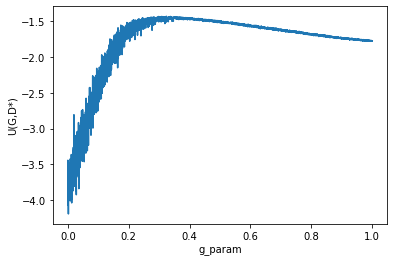

In [5]:
from matplotlib import cm

g_params = np.linspace(0, 1, 5000)
output = []

for g_param in g_params:
    generator = Generator(mu=g_param, sigma=0.1)
    u = U(generator, None) # 현재의 U 함수를 초기화
    out = u.forward(is_D_optimal=True)
    output.append(out)

print(f"[Optimal Saddle Point] g_param = {position[0]:.2f} / the highest output: {max(output)}")

# 그래프 출력
plt.plot(g_params, output)
plt.xlabel('g_param')
plt.ylabel('U(G,D*)')
plt.show()